In [ ]:
!pip install yfinance
!pip install yahoofinancials
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
import numpy as np
from matplotlib import pyplot
from numpy import concatenate
from sklearn.metrics import mean_squared_error
from math import sqrt

  Using cached yfinance-0.1.70-py2.py3-none-any.whl (26 kB)
  Using cached requests-2.27.1-py2.py3-none-any.whl (63 kB)
  Using cached lxml-4.8.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (6.4 MB)
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


# Data Preparation
Stock data is collected from 2020-01-01 to 2022-01-01. Each stock data is scaled. The stock data is converted to supervised learning.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from pandas import concat

#normalizing data
def df_preprocessor(df, sc):
  scaled_set = sc.fit_transform(df)
  return pd.DataFrame(scaled_set, columns = df.columns)

#converting series to supervised learning, n_out = how many steps to shift data backwards
def series_to_supervised(df, n_out):
  n_vars = df.shape[1]
  cols = []
  names = []
  cols.append(df.shift(1))
  names += [('%s(t-%d)' % (df.columns[j], 1)) for j in range(n_vars)]
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
	    names += [('%s(t)' % (df.columns[j])) for j in range(n_vars)]
    else:
	    names += [('%s(t+%d)' % (df.columns[j], i)) for j in range(n_vars)]
  final = concat(cols, axis = 1)
  final.columns = names
  final.dropna(inplace = True)
  return final

#generate a prepared dataframe for a company
def df_generator(company, sc):
  df =  yf.download(company,
                        start='2020-01-01',
                        end='2022-01-01',
                        progress=False)
  column = (df["High"] + df["Low"]) / 2
  df["Middle"] = column
  #normalize features
  scaled = df_preprocessor(df, sc)
  #frame to supervised learning
  reframed = series_to_supervised(scaled, 1)
  reframed.drop(reframed.columns[[7, 8, 9, 10, 11, 12]], axis=1, inplace=True)
  return reframed

# Stock Indexes
The stock index of each of the $40$ companies is placed in a list. For each company, a DataFrame is appended to a list based on the company's industry.

In [ ]:
software = ["MSFT", "ADBE", "NOW", "DBX", "IFS", "ORCL", "CRM", "ADSK", "AAPL", "GOOG"]
biomedical = ["AXSM", "JNJ", "RHHBY", "PFE", "ABBV", "LLY", "NVO", "MRK", "NVO", "AZN"]
banking = ["JPM", "BAC", "1398.HK", "CICHY", "WFC", "ACGBY", "3968.HK", "MS", "RY", "BACHF"]
news = ["CMCSA", "BCE", "WBD", "TRI", "RCI", "NPSNY", "FOX", "PARA", "LSXMB", "NWS"]
df_software = []
df_biomedical = []
df_banking = []
df_news = []

In [ ]:
# splits the data into rows of training and testing sets based on test size
def split_data(test_size, df):
  df_train = df[:-test_size]
  df_test = df[-test_size:]
  return df_train, df_test

# Data split, Model, Plot generation
The data is split into train and test sets here. The model trains using the data. The actual and predicted values are graphed. 


In [ ]:
# split into train and test tests 
def train_and_graph(df, sc):
  values = df.values
  n_days = int(0.3 * len(df))
  train = values[:-n_days, :]
  test = values[-n_days:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  # design network
  model = Sequential()
  model.add(LSTM(len(df)-n_days, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))
  model.compile(loss='mae', optimizer='adam')
  history = model.fit(train_X, train_y, epochs=25, batch_size=128, 
                      validation_data=(test_X, test_y), verbose=0, shuffle=False)
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.xlabel("Epochs")
  pyplot.ylabel("Loss")
  pyplot.legend()
  pyplot.show()
  yhat = model.predict(test_X)
  # invert scaling for forecast
  test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
  inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
  inv_yhat = sc.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,0]
  # invert scaling for actual
  test_y = test_y.reshape((len(test_y), 1))
  inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
  inv_y = sc.inverse_transform(inv_y)
  inv_y = inv_y[:,0]
  rmse = sqrt(mean_squared_error(test_y, yhat))
  pyplot.plot(inv_y, label = 'actual')
  pyplot.plot(inv_yhat, label = 'predicted')
  pyplot.xlabel("Days after January 1 2020")
  pyplot.ylabel("Stock Price")
  pyplot.legend()
  pyplot.show()

  print('Test RMSE: %.3f' % rmse + "\n")
  return(float(rmse), model)

# Graph Drawings
The actual graphs are drawn here. For each company, there are two graphs. The first graph shows loss as a function of the epochs for training and testing samples. The second graph shows the actual versus predicted stock prices.

Software:

MSFT



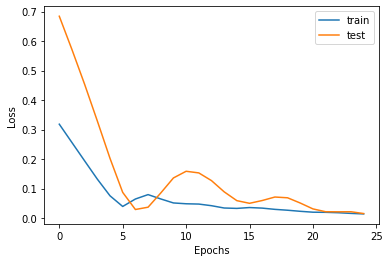

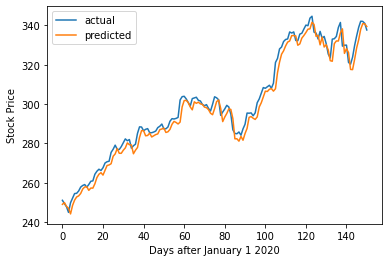

Test RMSE: 0.019

ADBE



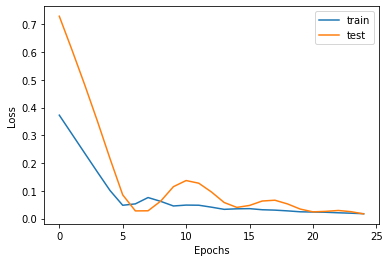

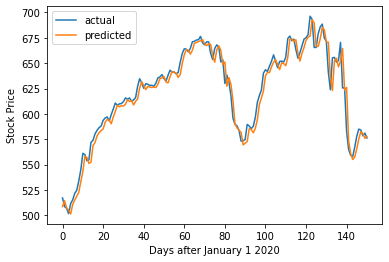

Test RMSE: 0.024

NOW



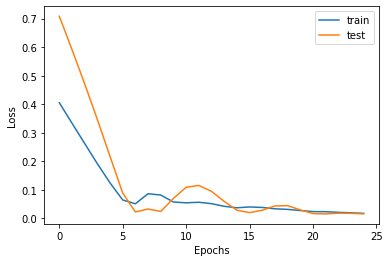

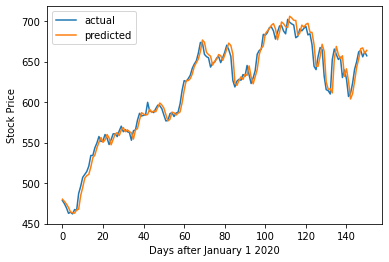

Test RMSE: 0.022

DBX



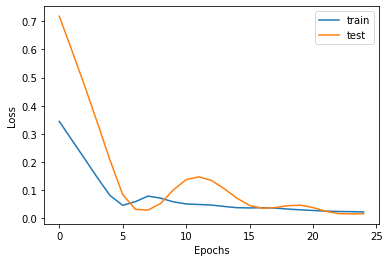

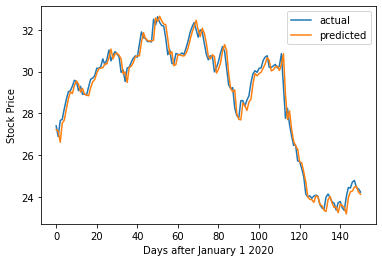

Test RMSE: 0.022

IFS



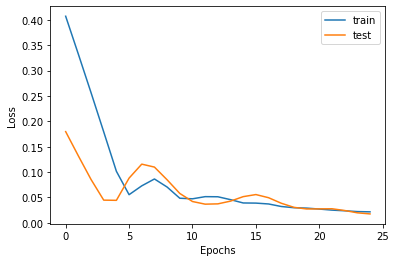

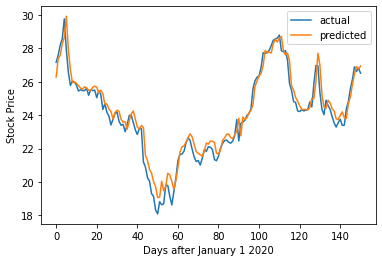

Test RMSE: 0.023

ORCL



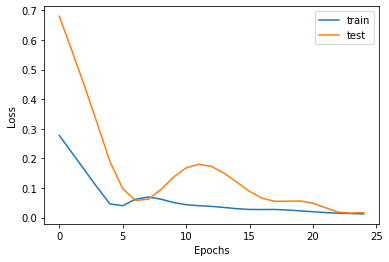

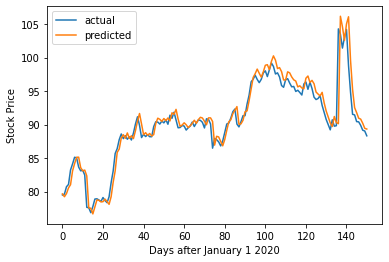

Test RMSE: 0.028

CRM



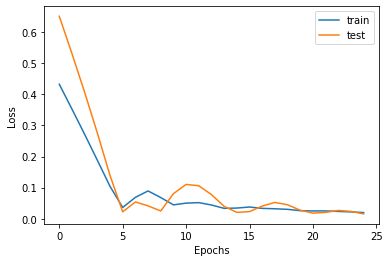

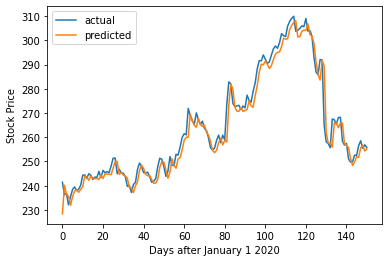

Test RMSE: 0.023

ADSK



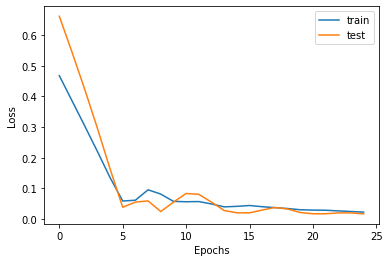

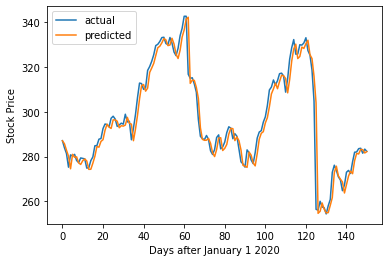

Test RMSE: 0.028

AAPL



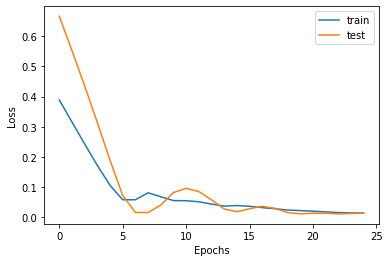

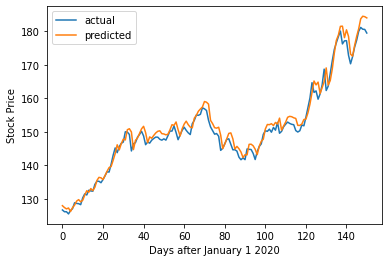

Test RMSE: 0.017

GOOG



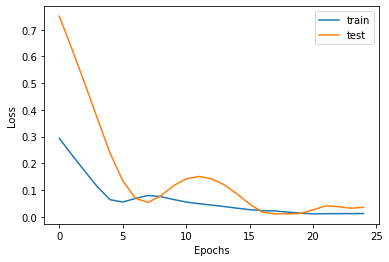

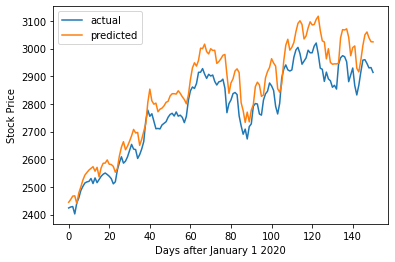

Test RMSE: 0.039

0.024502849234875834


Biomedical:

AXSM



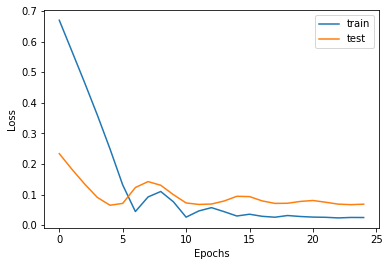

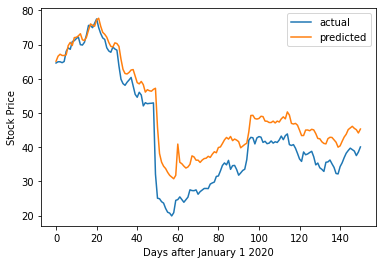

Test RMSE: 0.080

JNJ



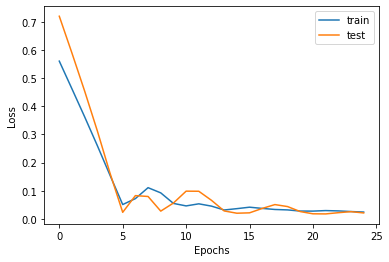

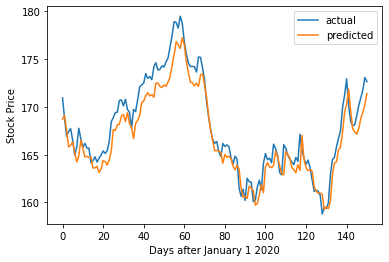

Test RMSE: 0.026

RHHBY



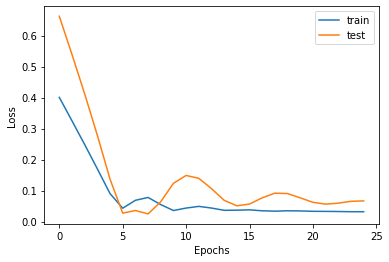

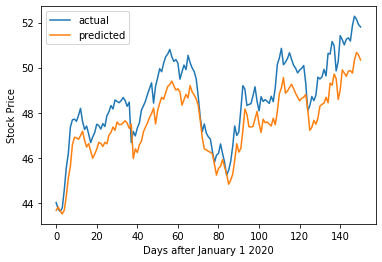

Test RMSE: 0.073

PFE



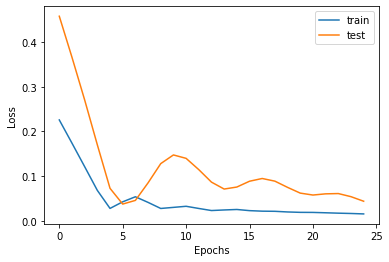

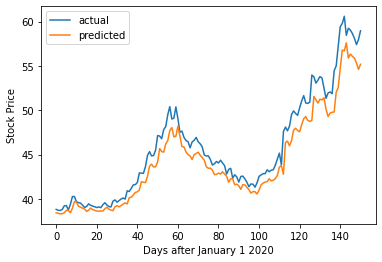

Test RMSE: 0.054

ABBV



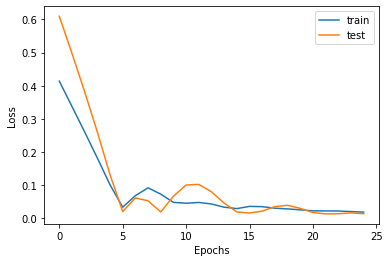

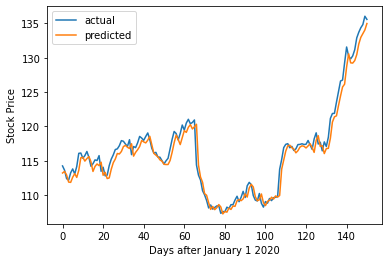

Test RMSE: 0.018

LLY



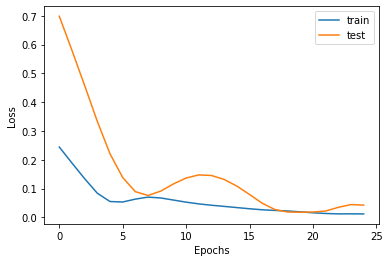

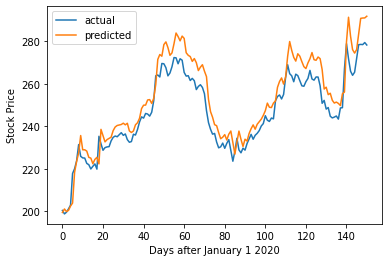

Test RMSE: 0.050

NVO



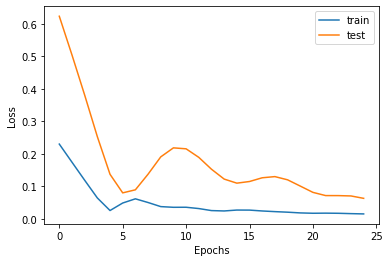

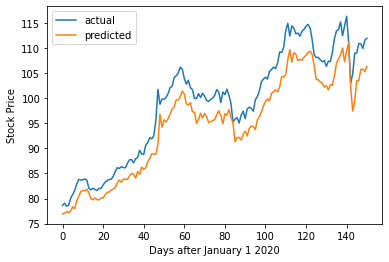

Test RMSE: 0.069

MRK



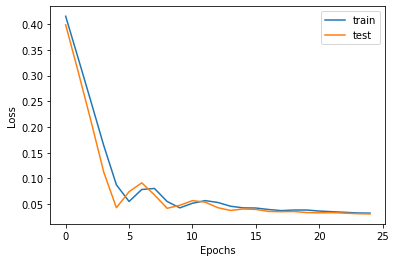

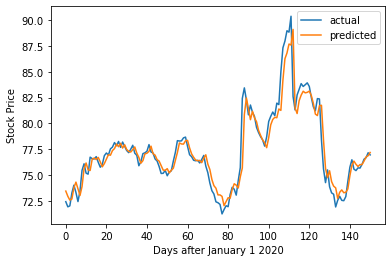

Test RMSE: 0.048

NVO



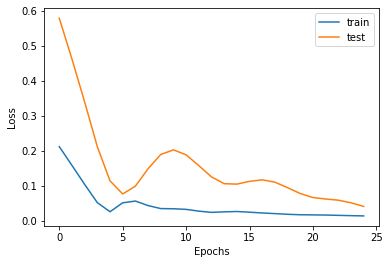

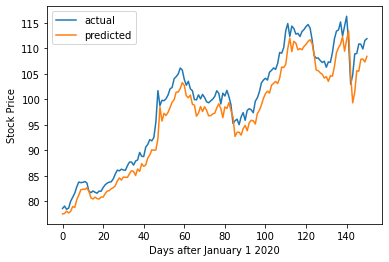

Test RMSE: 0.046

AZN



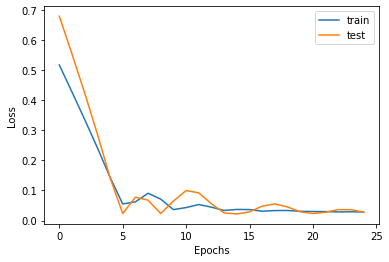

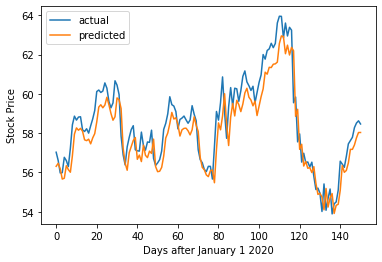

Test RMSE: 0.034

0.04972791540623335


Banking:

JPM



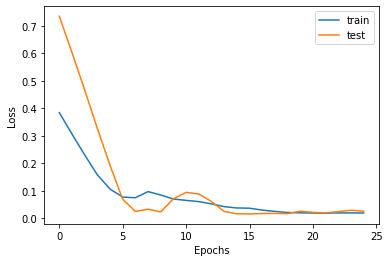

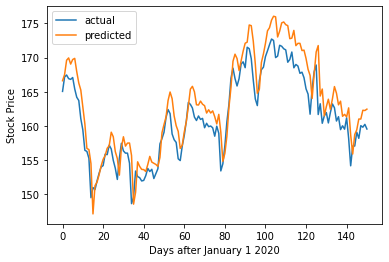

Test RMSE: 0.032

BAC



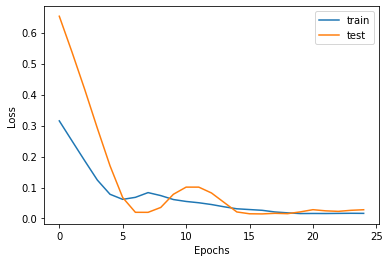

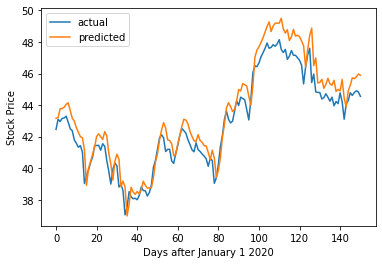

Test RMSE: 0.034

1398.HK



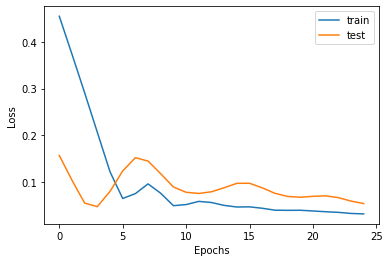

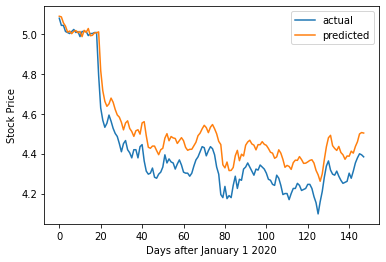

Test RMSE: 0.058

CICHY



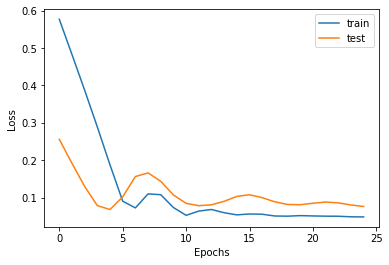

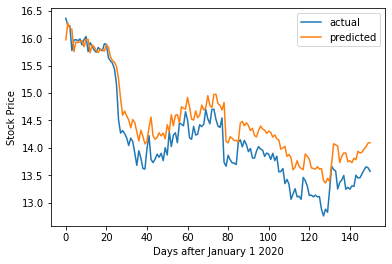

Test RMSE: 0.087

WFC



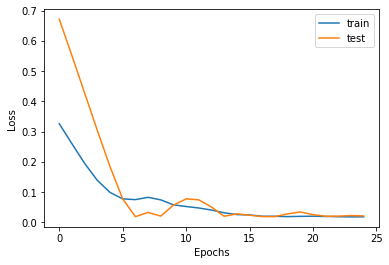

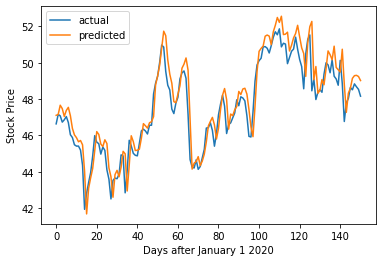

Test RMSE: 0.028

ACGBY



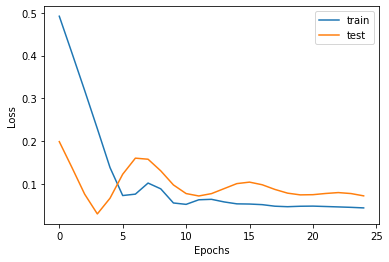

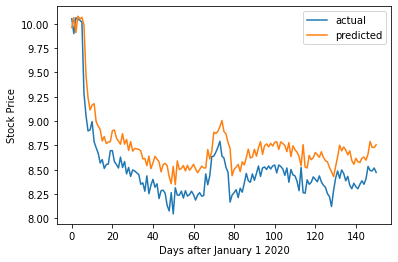

Test RMSE: 0.078

3968.HK



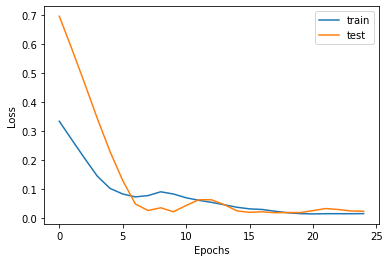

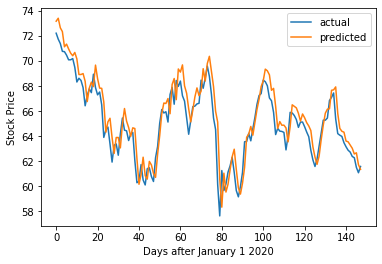

Test RMSE: 0.031

MS



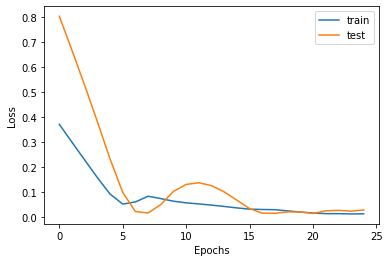

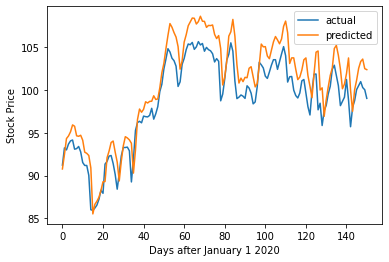

Test RMSE: 0.033

RY



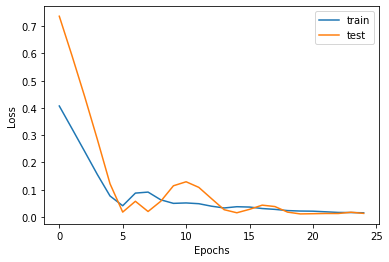

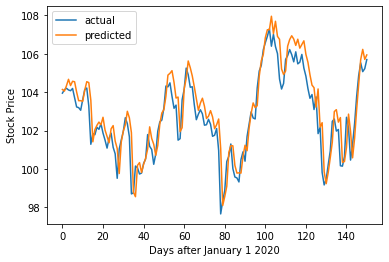

Test RMSE: 0.017

BACHF



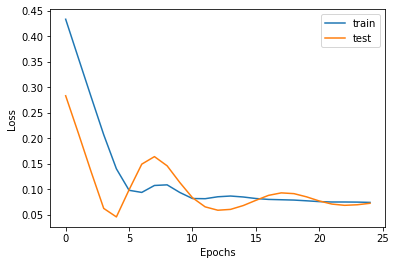

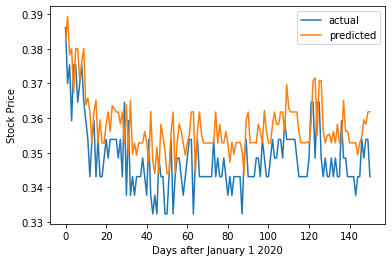

Test RMSE: 0.085

0.048205068552805555


Media and Press:

CMCSA



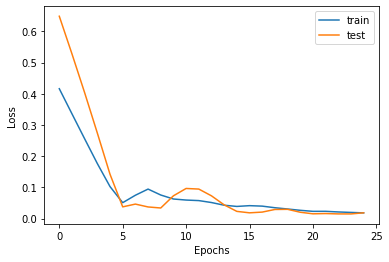

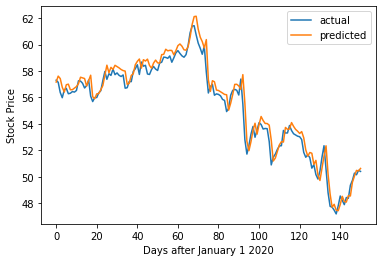

Test RMSE: 0.024

BCE



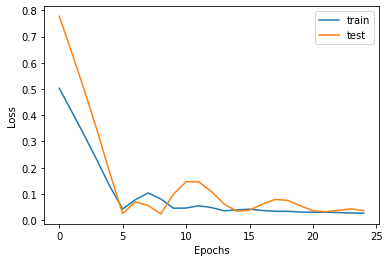

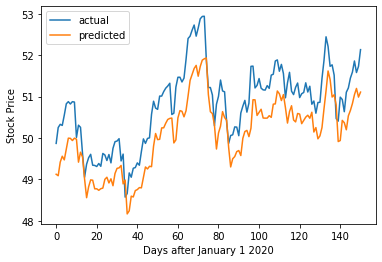

Test RMSE: 0.039

WBD



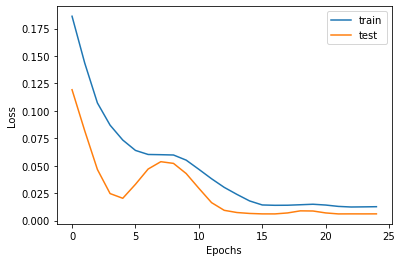

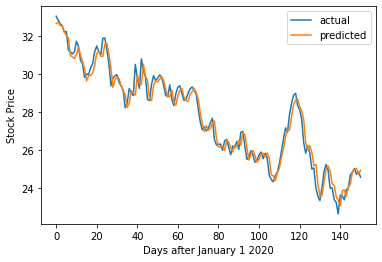

Test RMSE: 0.008

TRI



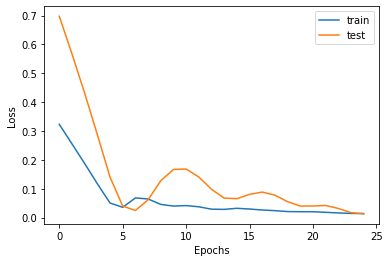

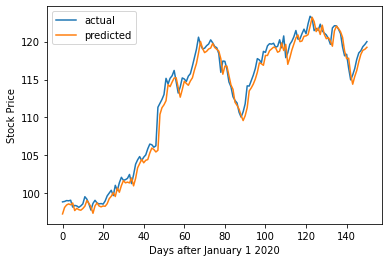

Test RMSE: 0.016

RCI



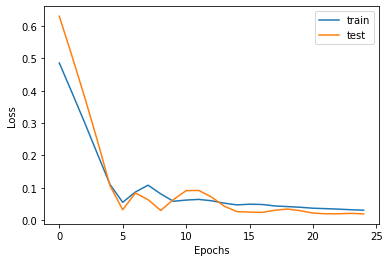

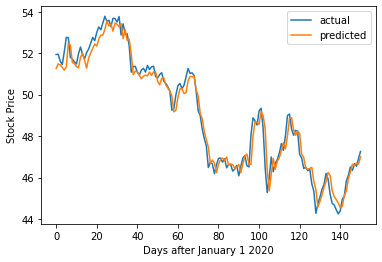

Test RMSE: 0.025

NPSNY



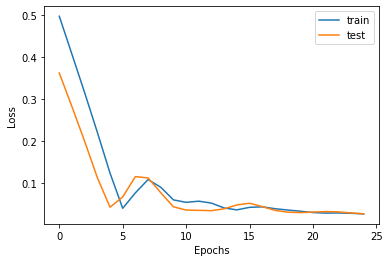

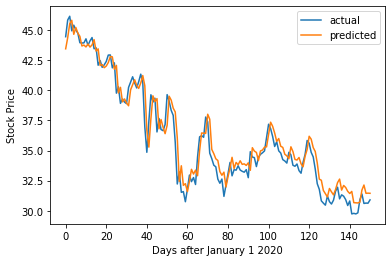

Test RMSE: 0.034

FOX



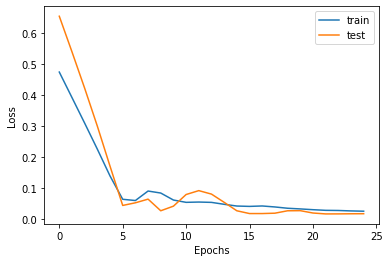

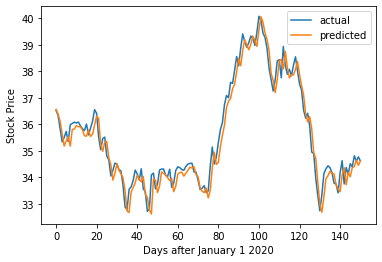

Test RMSE: 0.020

PARA



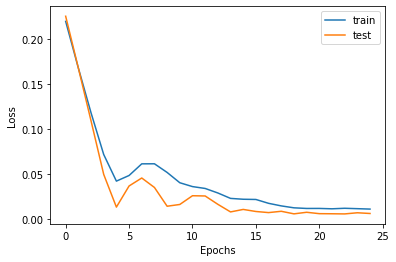

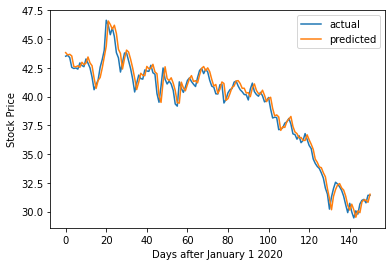

Test RMSE: 0.007

LSXMB



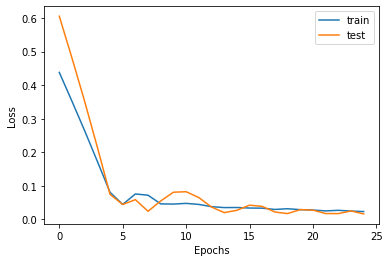

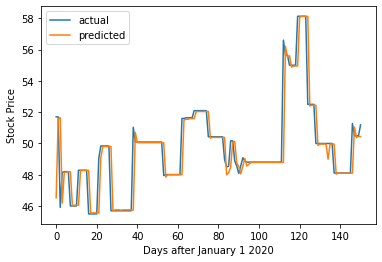

Test RMSE: 0.041

NWS



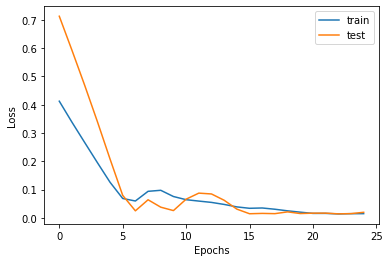

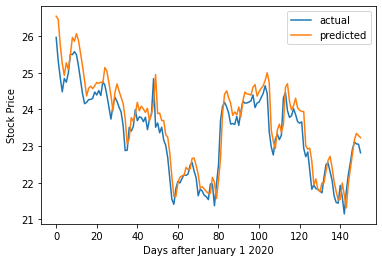

Test RMSE: 0.024

0.023922012860889776




In [ ]:
def display_results(n):
  print("Software:\n")
  software_rmse = 0
  for i in range(0, n):
    print(software[i] + "\n")
    sc = MinMaxScaler(feature_range=(0, 1))
    df = df_generator(software[i], sc)
    df_software.append(df)
    software_rmse += train_and_graph(df, sc)[0]
  print(software_rmse / n)
  print("\n")

  print("Biomedical:\n")
  biomedical_rmse = 0
  for i in range(0, n):
    print(biomedical[i] + "\n")
    sc = MinMaxScaler(feature_range=(0, 1))
    df = df_generator(biomedical[i], sc)
    df_biomedical.append(df)
    biomedical_rmse += train_and_graph(df, sc)[0]
  print(biomedical_rmse / n)
  print("\n")

  print("Banking:\n")
  banking_rmse = 0
  for i in range(0, n):
    print(banking[i] + "\n")
    sc = MinMaxScaler(feature_range=(0, 1))
    df = df_generator(banking[i], sc)
    df_banking.append(df)
    banking_rmse += train_and_graph(df, sc)[0]
  print(banking_rmse / n)
  print("\n")

  print("Media and Press:\n")
  news_rmse = 0
  for i in range(0, n):
    print(news[i] + "\n")
    sc = MinMaxScaler(feature_range=(0, 1))
    df = df_generator(news[i], sc)
    df_news.append(df)
    news_rmse += train_and_graph(df, sc)[0]
  print(news_rmse / n)
  print("\n")
  

display_results(10)

# Variance of companies

In [ ]:
#measure variance in data across industries 

def industry_variances(n):
  print("Software:")
  software_var = 0
  for i in range(0, n):
    software_var += df_software[i].var()["Middle(t)"]
  print(software_var / n)
  print("")

  print("Biomedical:")
  biomedical_var = 0
  for i in range(0, n):
    biomedical_var += df_biomedical[i].var()["Middle(t)"]
  print(biomedical_var / n)
  print("")

  print("Banking:")
  banking_var = 0
  for i in range(0, n):
    banking_var += df_banking[i].var()["Middle(t)"]
  print(banking_var / n)
  print("")  

  print("Media and Press:")
  news_var = 0
  for i in range(0, n):
    news_var += df_news[i].var()["Middle(t)"]
  print(news_var / n)
  print("")

industry_variances(2)

Software:
0.06079935512506024

Biomedical:
0.04293892822359462

Banking:
0.08613554396108891

Media and Press:
0.054262173067882495



# Validation

Software:

MSFT



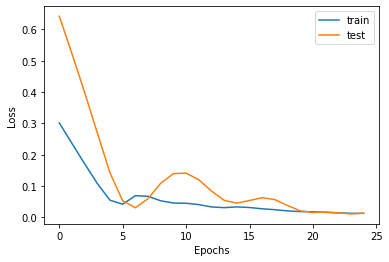

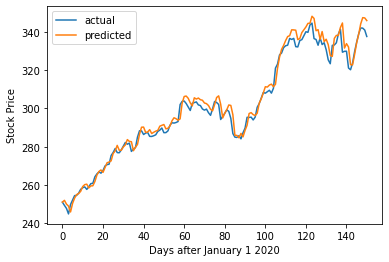

Test RMSE: 0.018



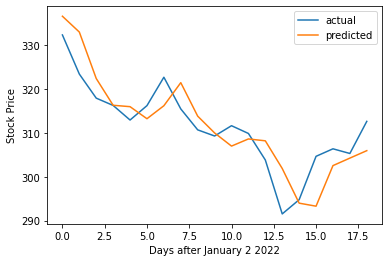

Test RMSE: 0.126

ADBE



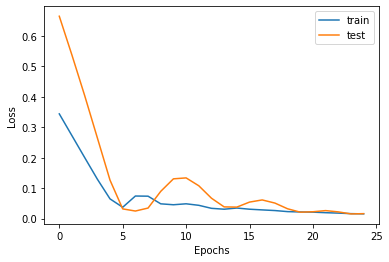

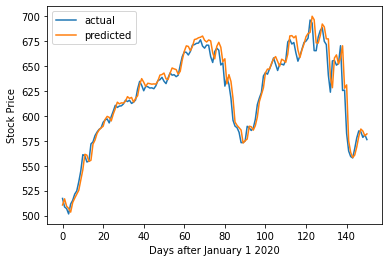

Test RMSE: 0.025



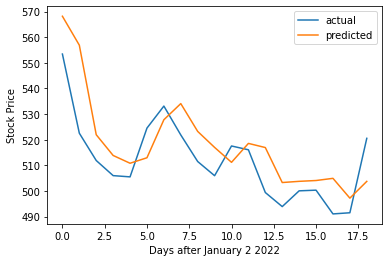

Test RMSE: 0.170

NOW



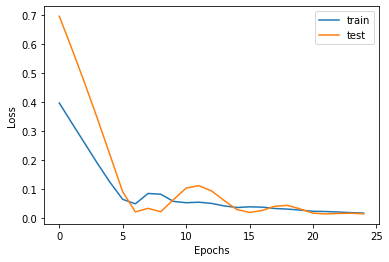

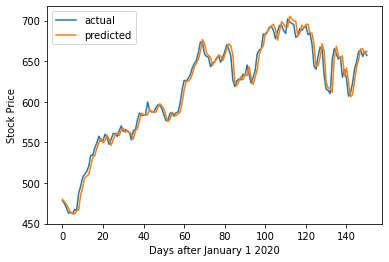

Test RMSE: 0.021



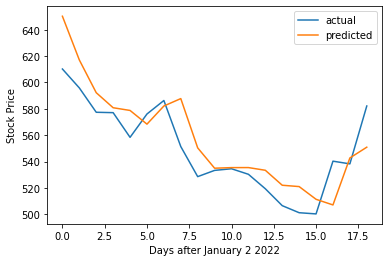

Test RMSE: 0.136

DBX



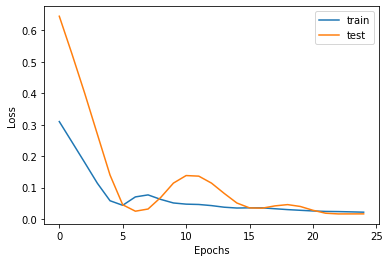

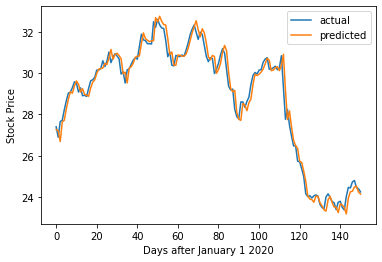

Test RMSE: 0.023



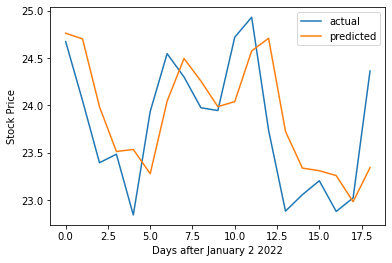

Test RMSE: 0.260

IFS



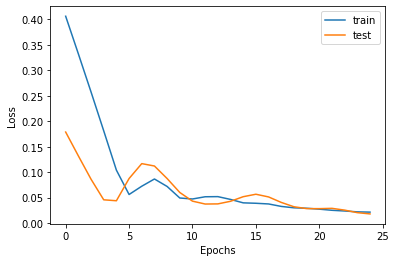

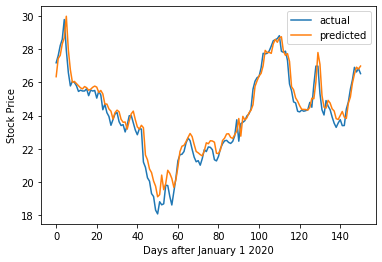

Test RMSE: 0.024



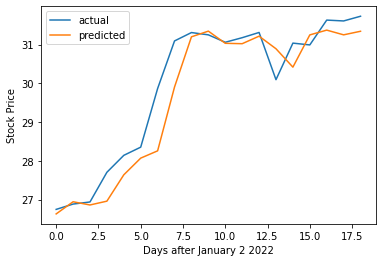

Test RMSE: 0.110

ORCL



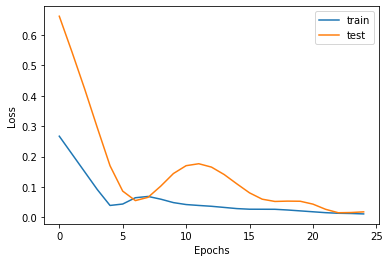

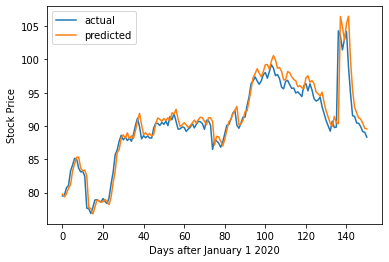

Test RMSE: 0.030



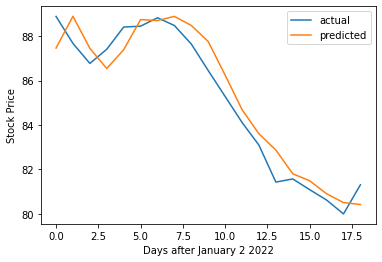

Test RMSE: 0.094

CRM



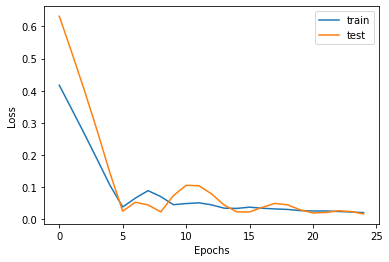

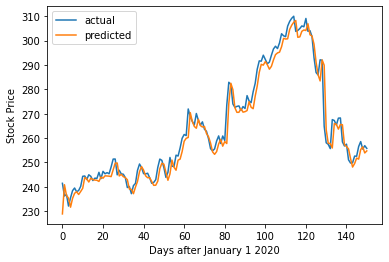

Test RMSE: 0.023



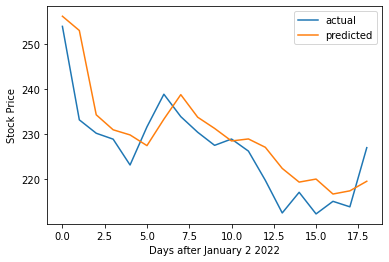

Test RMSE: 0.150

ADSK



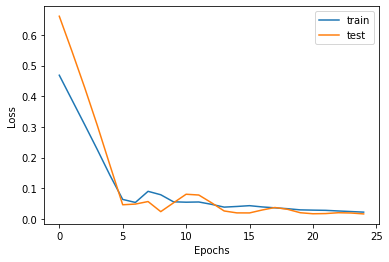

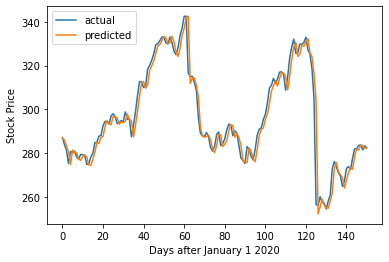

Test RMSE: 0.028



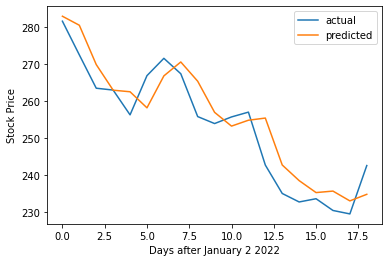

Test RMSE: 0.115

AAPL



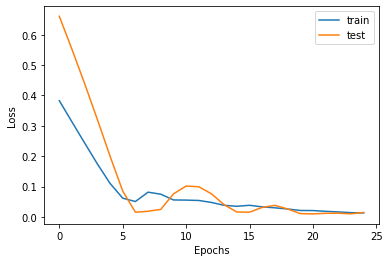

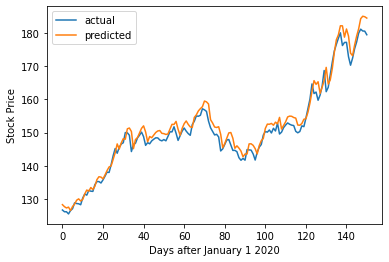

Test RMSE: 0.019



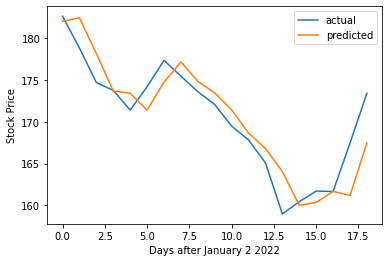

Test RMSE: 0.123

GOOG



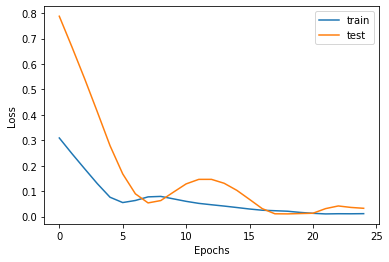

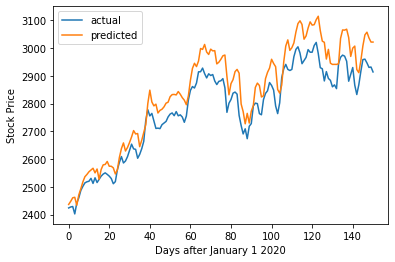

Test RMSE: 0.037



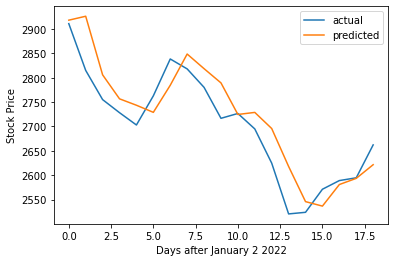

Test RMSE: 0.129

test 0.02472107054521765
validation 0.14126947165674444


Biomedical:

JPM



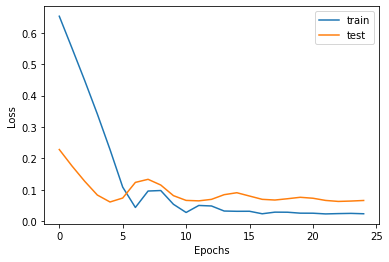

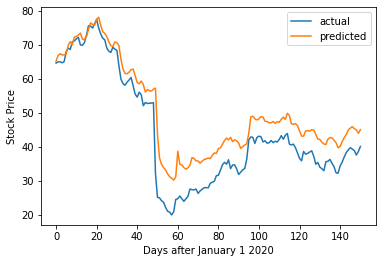

Test RMSE: 0.077



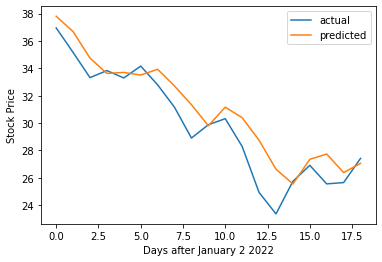

Test RMSE: 0.113

BAC



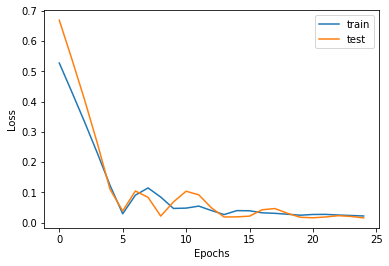

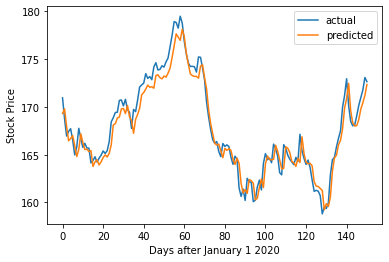

Test RMSE: 0.019



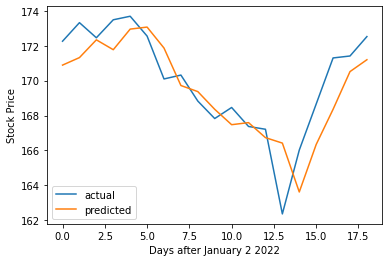

Test RMSE: 0.149

1398.HK



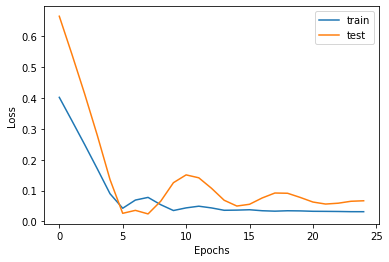

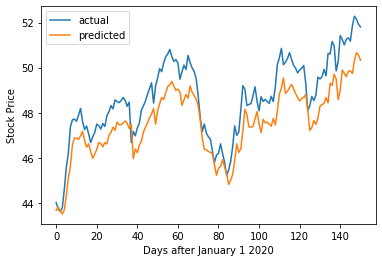

Test RMSE: 0.074



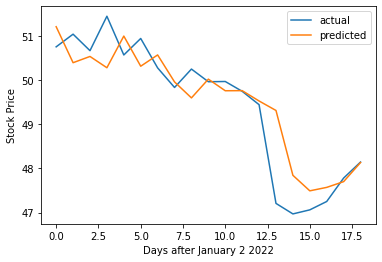

Test RMSE: 0.142

CICHY



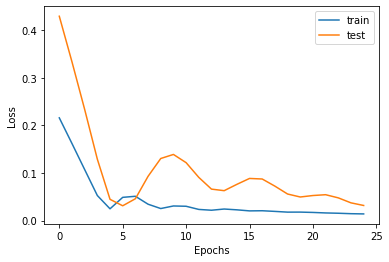

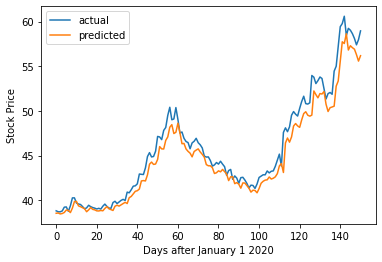

Test RMSE: 0.041



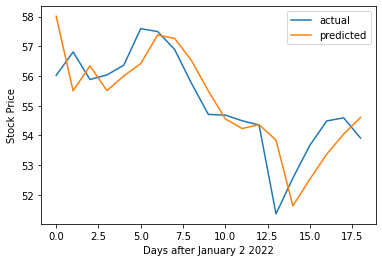

Test RMSE: 0.142

WFC



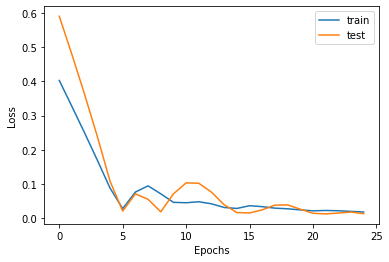

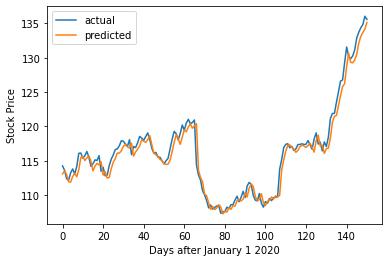

Test RMSE: 0.017



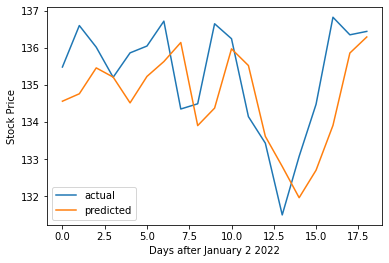

Test RMSE: 0.250

ACGBY



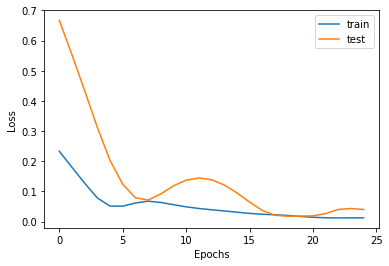

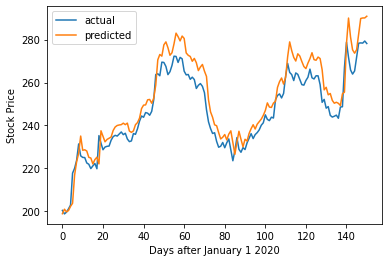

Test RMSE: 0.047



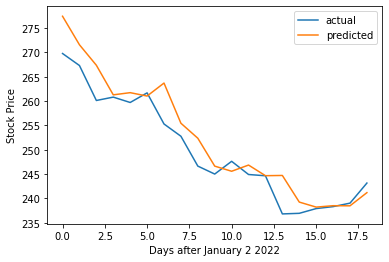

Test RMSE: 0.110

3968.HK



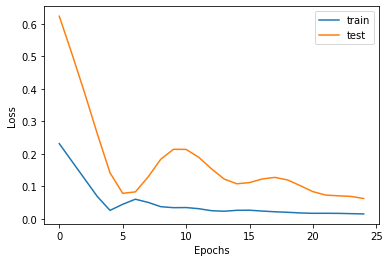

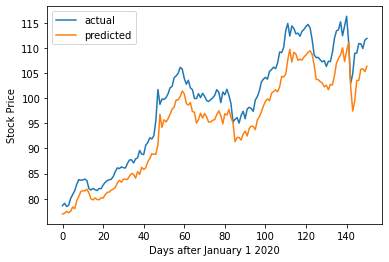

Test RMSE: 0.068



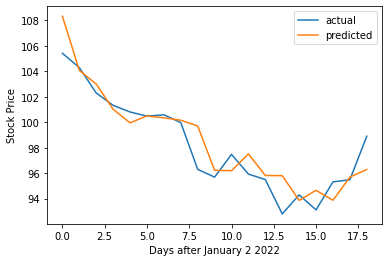

Test RMSE: 0.093

MS



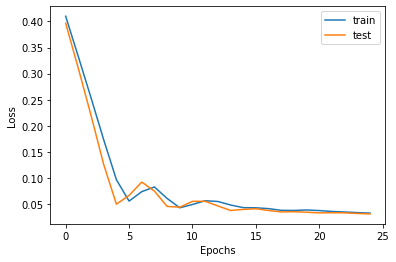

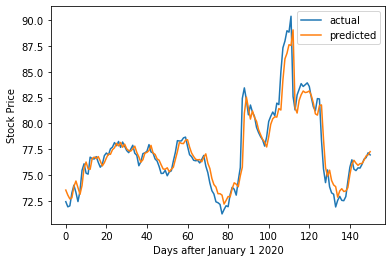

Test RMSE: 0.049



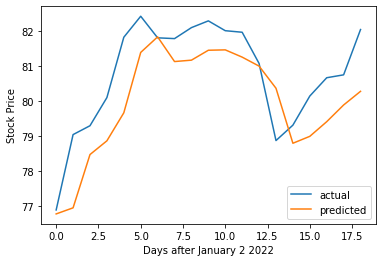

Test RMSE: 0.188

RY



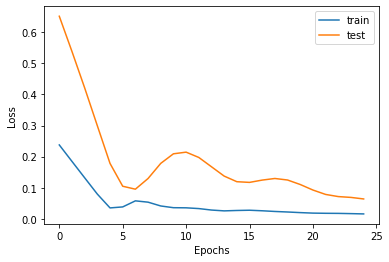

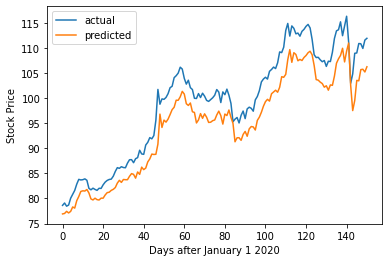

Test RMSE: 0.069



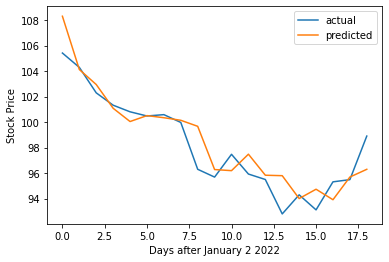

Test RMSE: 0.092

BACHF



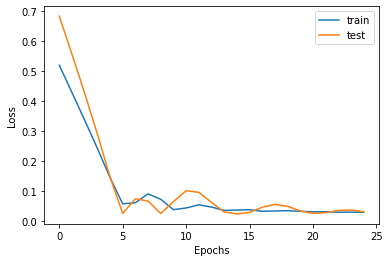

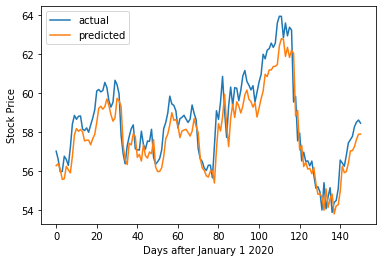

Test RMSE: 0.036



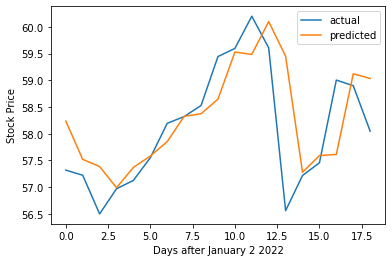

Test RMSE: 0.237

test 0.04968588791089581
validation 0.15169813551263728


Banking:

JPM



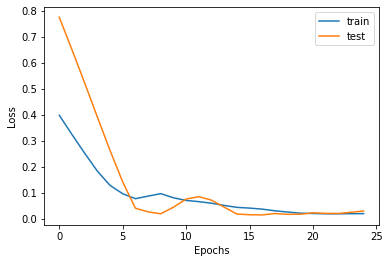

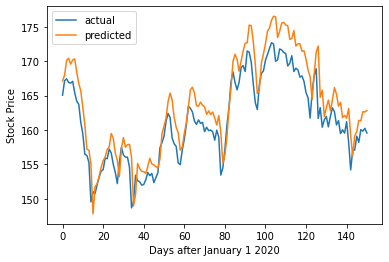

Test RMSE: 0.035



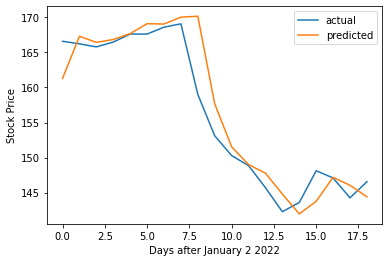

Test RMSE: 0.127

BAC



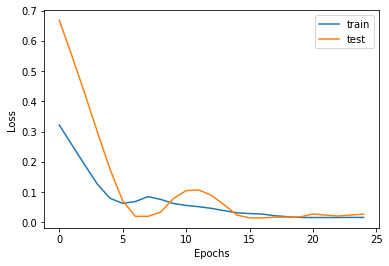

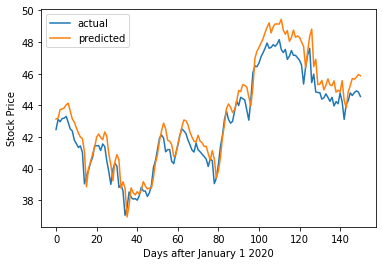

Test RMSE: 0.033



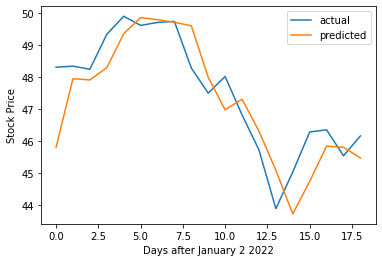

Test RMSE: 0.162

1398.HK



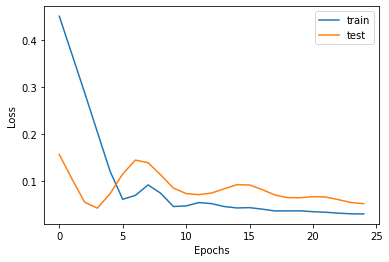

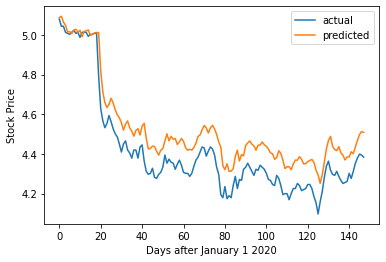

Test RMSE: 0.058



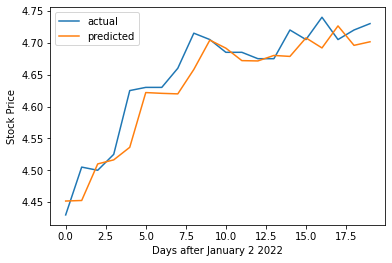

Test RMSE: 0.108

CICHY



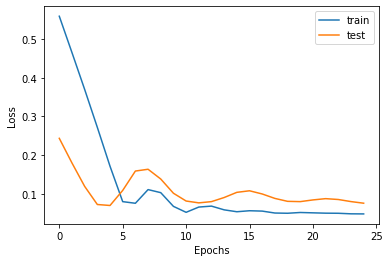

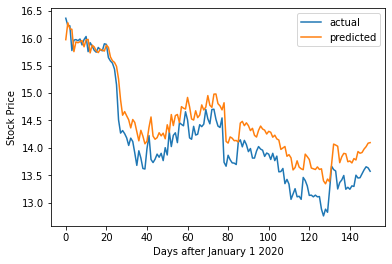

Test RMSE: 0.087



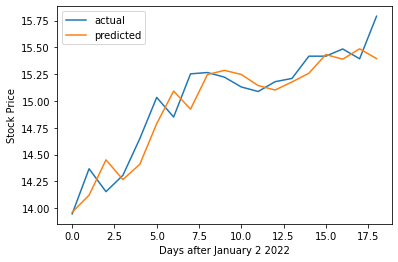

Test RMSE: 0.092

WFC



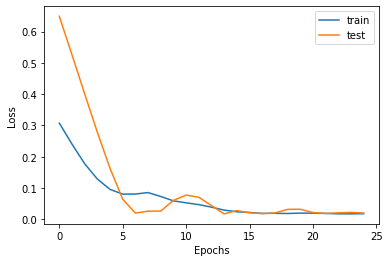

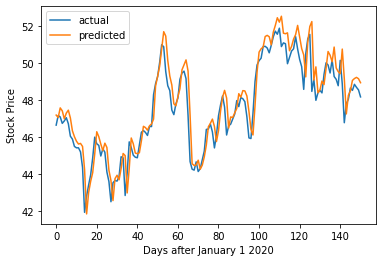

Test RMSE: 0.028



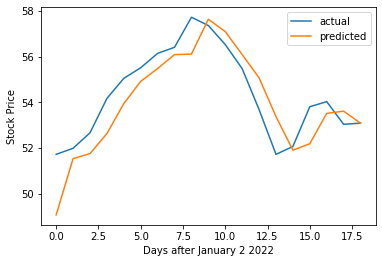

Test RMSE: 0.127

ACGBY



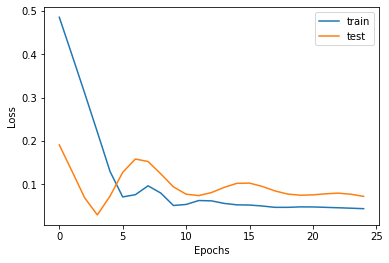

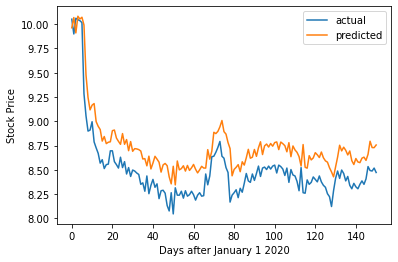

Test RMSE: 0.078



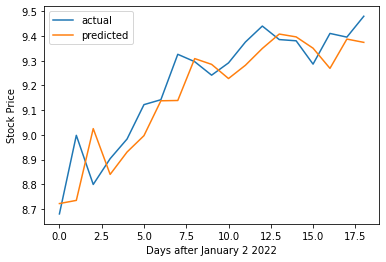

Test RMSE: 0.135

3968.HK



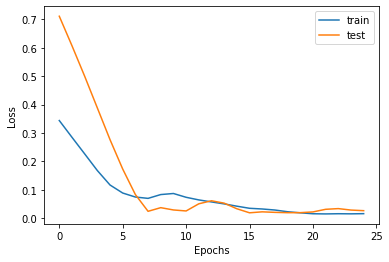

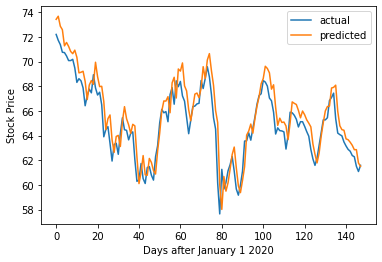

Test RMSE: 0.033



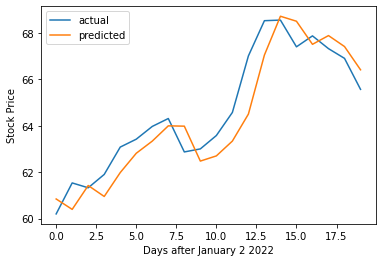

Test RMSE: 0.119

MS



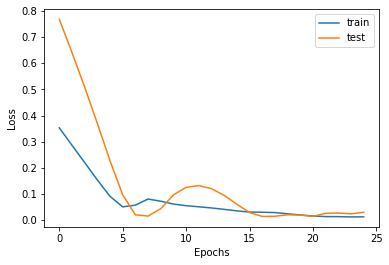

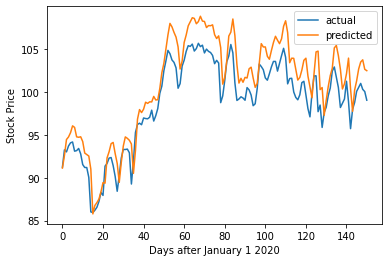

Test RMSE: 0.034



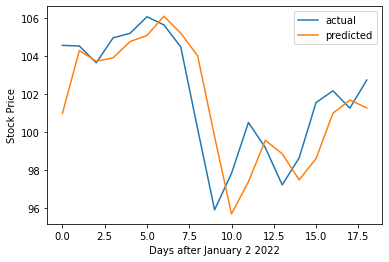

Test RMSE: 0.197

RY



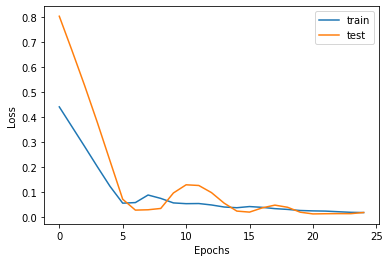

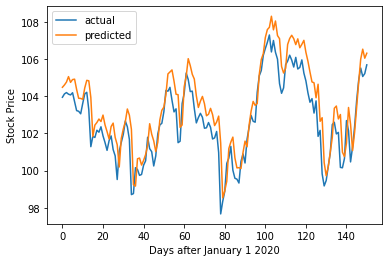

Test RMSE: 0.021



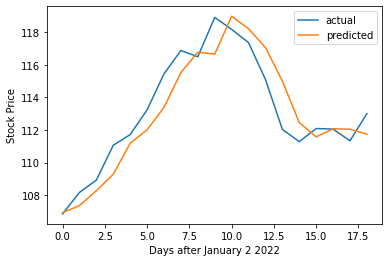

Test RMSE: 0.108

BACHF



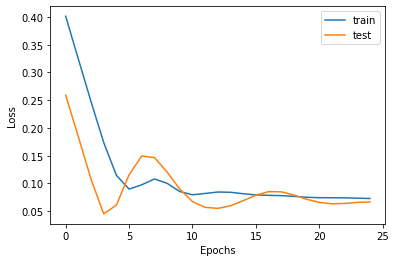

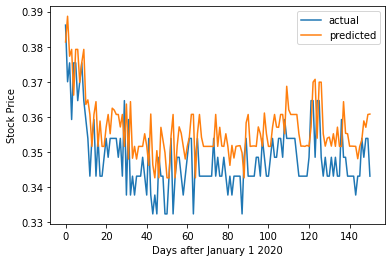

Test RMSE: 0.079



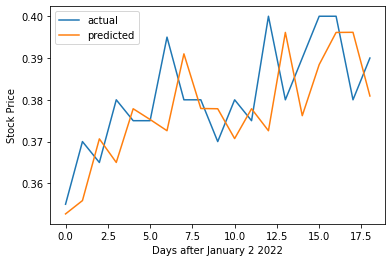

Test RMSE: 0.249

test 0.048530919929325345
validation 0.14250288661085694


Media and Press:

CMCSA



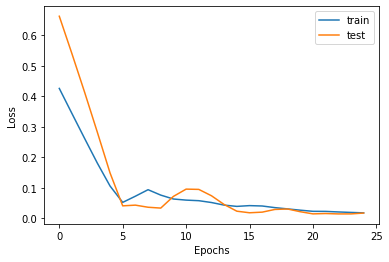

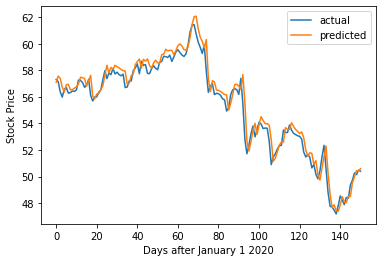

Test RMSE: 0.024



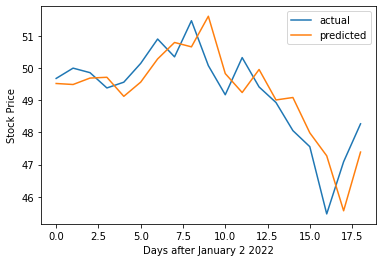

Test RMSE: 0.143

BCE



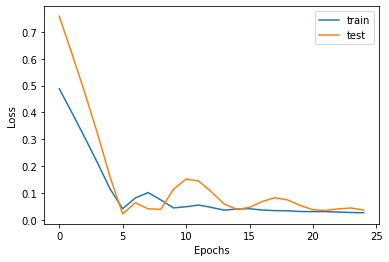

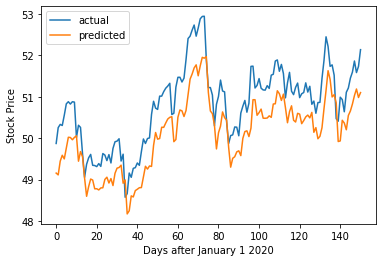

Test RMSE: 0.039



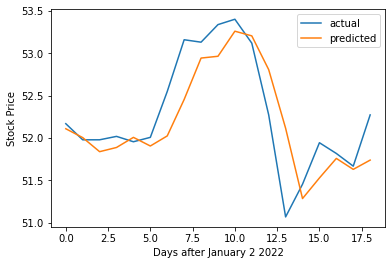

Test RMSE: 0.167

WBD



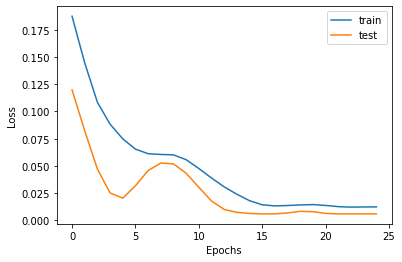

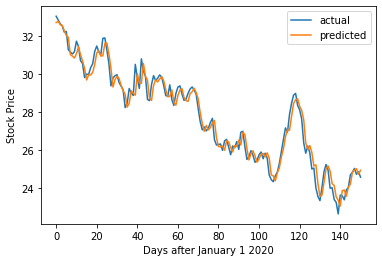

Test RMSE: 0.008



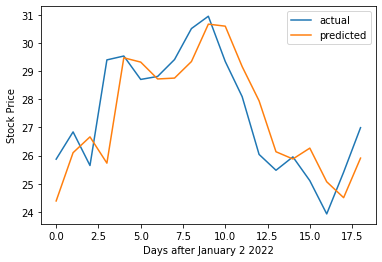

Test RMSE: 0.181

TRI



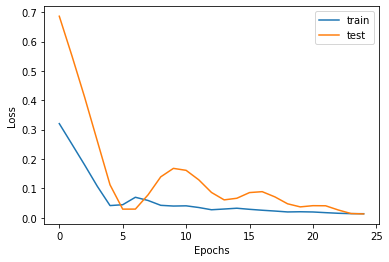

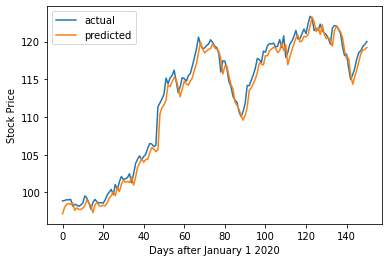

Test RMSE: 0.016



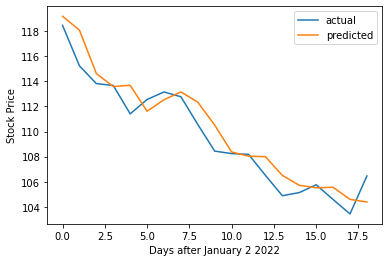

Test RMSE: 0.086

RCI



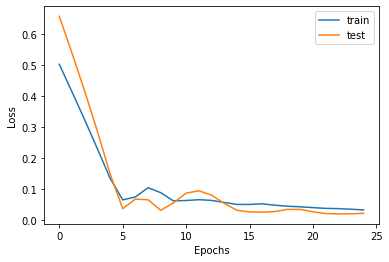

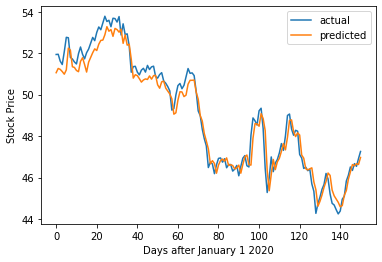

Test RMSE: 0.027



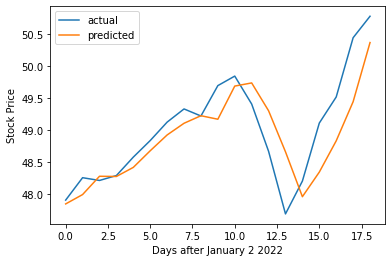

Test RMSE: 0.152

NPSNY



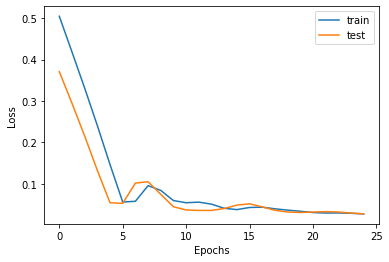

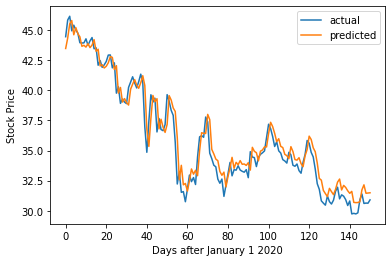

Test RMSE: 0.034



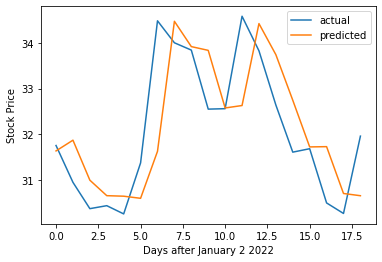

Test RMSE: 0.250

FOX



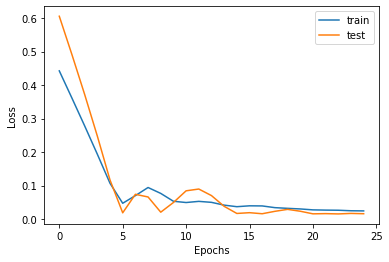

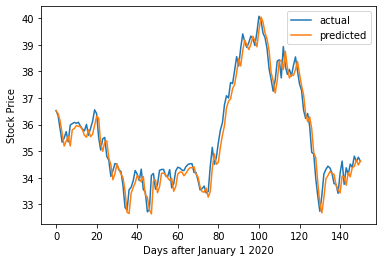

Test RMSE: 0.020



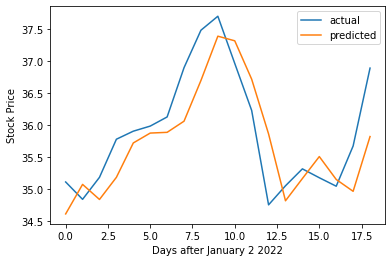

Test RMSE: 0.167

PARA



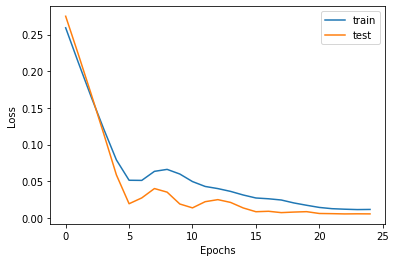

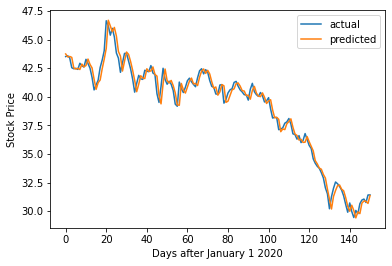

Test RMSE: 0.007



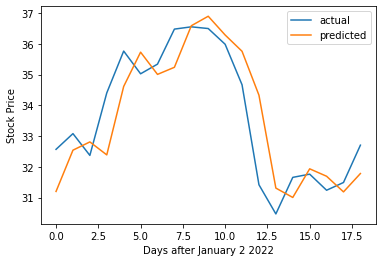

Test RMSE: 0.177

LSXMB



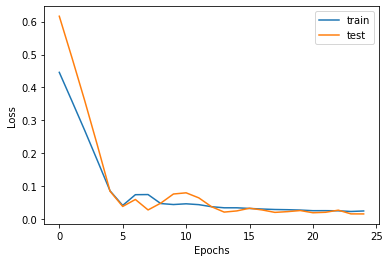

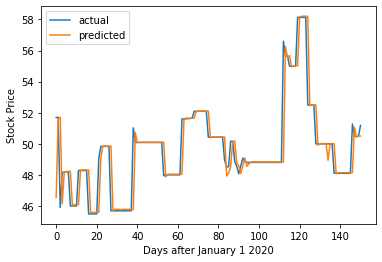

Test RMSE: 0.041



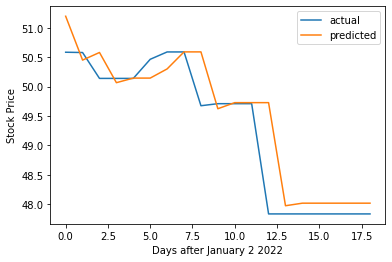

Test RMSE: 0.159

NWS



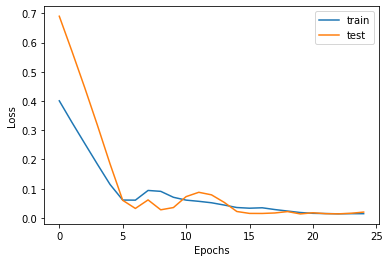

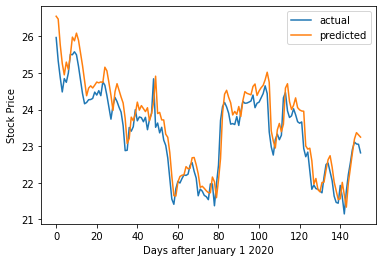

Test RMSE: 0.025



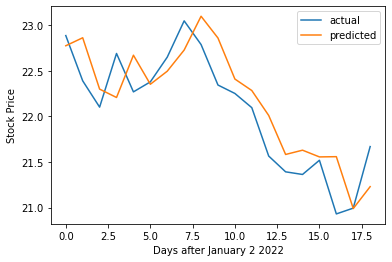

Test RMSE: 0.157

test 0.02409905898131671
validation 0.16399782392903522




In [ ]:
# #validation
def df_generator_validation(company, sc):
  df =  yf.download(company,
                        start='2022-01-01',
                        end='2022-02-01',
                        progress=False)
  column = (df["High"] + df["Low"]) / 2
  df["Middle"] = column
  #normalize features
  scaled = df_preprocessor(df, sc)
  #frame to supervised learning
  reframed = series_to_supervised(scaled, 1)
  reframed.drop(reframed.columns[[7, 8, 9, 10, 11, 12]], axis=1, inplace=True)
  return reframed

def predict_validation(df, sc, model):
  values = df.values
  # split into input and outputs
  test_X, test_y = values[:, :-1], values[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  
  yhat = model.predict(test_X)
  # invert scaling for forecast
  test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
  inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
  inv_yhat = sc.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,0]
  # invert scaling for actual
  test_y = test_y.reshape((len(test_y), 1))
  inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
  inv_y = sc.inverse_transform(inv_y)
  inv_y = inv_y[:,0]
  rmse = sqrt(mean_squared_error(test_y, yhat))
  pyplot.plot(inv_y, label = 'actual')
  pyplot.plot(inv_yhat, label = 'predicted')
  pyplot.xlabel("Days after January 2 2022")
  pyplot.ylabel("Stock Price")
  pyplot.legend()
  pyplot.show()

  print('Test RMSE: %.3f' % rmse + "\n")
  return(float(rmse), model)

def display_validation(n):
  print("Software:\n")
  software_rmse = 0
  software_rmse_validation = 0
  for i in range(0, n):
    print(software[i] + "\n")
    sc = MinMaxScaler(feature_range=(0, 1))
    df = df_generator(software[i], sc)
    df_software.append(df)
    temp_rmse, temp_model = train_and_graph(df, sc)
    software_rmse += temp_rmse
    
    #using the validation data to predict
    df_validation = df_generator_validation(software[i], sc)
    software_rmse_validation += predict_validation(df_validation, sc, temp_model)[0]

  print("test", software_rmse / n)
  print("validation", software_rmse_validation / n)
  print("\n")


  print("Biomedical:\n")
  biomedical_rmse = 0
  biomedical_rmse_validation = 0
  for i in range(0, n):
    print(banking[i] + "\n")
    sc = MinMaxScaler(feature_range=(0, 1))
    df = df_generator(biomedical[i], sc)
    df_biomedical.append(df)
    temp_rmse, temp_model = train_and_graph(df, sc)
    biomedical_rmse += temp_rmse
    
    #using the validation data to predict
    df_validation = df_generator_validation(biomedical[i], sc)
    biomedical_rmse_validation += predict_validation(df_validation, sc, temp_model)[0]

  print("test", biomedical_rmse / n)
  print("validation", biomedical_rmse_validation / n)
  print("\n")

  print("Banking:\n")
  banking_rmse = 0
  banking_rmse_validation = 0
  for i in range(0, n):
    print(banking[i] + "\n")
    sc = MinMaxScaler(feature_range=(0, 1))
    df = df_generator(banking[i], sc)
    df_banking.append(df)
    temp_rmse, temp_model = train_and_graph(df, sc)
    banking_rmse += temp_rmse
    
    #using the validation data to predict
    df_validation = df_generator_validation(banking[i], sc)
    banking_rmse_validation += predict_validation(df_validation, sc, temp_model)[0]

  print("test", banking_rmse / n)
  print("validation", banking_rmse_validation / n)
  print("\n")


  print("Media and Press:\n")
  news_rmse = 0
  news_rmse_validation = 0
  for i in range(0, n):
    print(news[i] + "\n")
    sc = MinMaxScaler(feature_range=(0, 1))
    df = df_generator(news[i], sc)
    df_news.append(df)
    temp_rmse, temp_model = train_and_graph(df, sc)
    news_rmse += temp_rmse
    
    #using the validation data to predict
    df_validation = df_generator_validation(news[i], sc)
    news_rmse_validation += predict_validation(df_validation, sc, temp_model)[0]

  print("test", news_rmse / n)
  print("validation", news_rmse_validation / n)
  print("\n")

display_validation(10)


An Earlier Example of Univariate LSTM

In [ ]:
	
# univariate lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 

# print(display(df_software[0]))


# split a univariate sequence into samples
def split_sequence(sequence:list, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
# display(df_software[0].Close[0:99])
raw_seq = df_software[0].Close[0:400]
# choose a number of time steps
n_steps = 60
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction
input_x = df_software[0].Close[(501-n_steps):501]
x_input = array(input_x).reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(input_x[-10:])
print('time_step: ', n_steps)
print('y', df_software[0].Close[501])
print('y_hat', yhat)